# Photon-to-axion/dark-photon coupling solver in the case of costant magnetic field and in one halo. 

(SEE THE GENERAL NOTEBOOK FOR A MORE PRECISE TREATMENT OF THE MATTER)

Here we want to solve the photon-to-axion or the photon-to-dark_photon conversion equation in the case we are in an halo, with a certain halo model which gives the function $n_e(r)$ that should be mapped into $n_e(z)$ where $z$ is the axis representing the photon trajectory.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint, solve_ivp, ode
from scipy.stats import norm
from scipy.interpolate import CubicSpline, interp1d
from scipy.integrate import quad
from scipy.optimize import brentq

import math
import astropy.units as u
import astropy.constants as const


#OdeintW - wrapper to solve ODE with complex terms.
#import odeintw 
#from odeintw import odeintw


# Visual settings
%config InlineBackend.figure_format='retina'
%matplotlib inline

if '/Library/TeX/texbin/' not in os.environ["PATH"]:
    os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin/'
    
# Latex font
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import colors
plt.rcParams['figure.figsize'] = [9,7]  # Adjust the size as needed for the plots
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Want to study photon-to-axion or photon-to-dark-photon?

dark_photon = False #Set False if you want to work with axion

In [3]:
####################################
# Natural unit conversions
####################################

#We express all the quantities in eV
GeV = 1 
MeV = 1e-3
keV = 1e-6
eV  = 1e-9
meV = 1e-12 

#Units:
Kg     = 5.609 * 1e35 * eV
meter  = 5.07 * 1e6 * eV**-1
cm     = 1e-2 * meter
Km     = 1e3 * meter
Mpc    = 1.564 * 1e29 * eV**-1
second = 1.5192 * 1e15 * eV**-1
Hz     = 1/second


Gauss  = 1.95 * 1e-2 * eV**2
Joule  = 6.242 * 1e18 * eV  

#Constants
AlphaEM           = 1/137
H_0               = 67.66 * Km/second / Mpc
ElementaryCharge  = np.sqrt(4 * np.pi * AlphaEM);
mass_electron     = 9.109 * 1e-31 * Kg
mass_proton       = 1.672 * 1e-27 * Kg
numerical_density = 1/cm**3


In [48]:
########################################
# Specify parameters of the model
########################################

m_a   = 6.3e-13 * eV# Axion mass in eV
g_agg =  1e-10 * (GeV)**-1 # Axion photon-coupling in (GeV)^-1
nu    = 145 * 10**9 * Hz # Frequency in Hz 
omega = 2.*np.pi*nu # Angular frequency in Hz

if dark_photon:
    eps   = 1e-5 #photon-dark photon coupling “natural” values in the range 1e-13 - 10e-2 eV 



Here insert a good explanation of the trajectory inside the halo. 



In [58]:
########################################
# Specify the halo model: Battaglia's profile 
########################################

rvir  = 2
rmin  = 0.54 #Defines uniquely the trajectory, it must be higher than r_res = 1.4521732239327674
r_thr = np.logspace(-3, np.log10(rvir), 100000) # radius in Mpc

# Set some parameters (similar to Planck best-fit cosmo)
Omega_b = 0.049
Omega_m = 0.3175
h = 0.6711
H0 = 100*h*u.km/u.s/u.Mpc

z = 0 # redshift
rho_critz = (3*H0**2/(8*np.pi*const.G)).to(u.Msun/u.Mpc**3).value # Msun/Mpc^3


# Halo settings
M200c = 10**13.5 # Msun
R200c = 2 # Mpc


def get_ne_battaglia(r, M200c, R200c, z, rho_critz, Omega_b, Omega_m,
                     param_dict=None):
       """
       Computes Battaglia profile as a function of radius. 

       Parameters:
           r: Radius in Mpc
           M200c: M200c in Msun
           R200c: R200c in Mpc
           z: Redshift
           rho_crit_z: Critical density in Msun/Mpc^3
           param_dict: Optional parameters for profile

       Returns:
           Electron number density profile in (1/Mpc**3)

       """

       # Unit conversion
       m_p = 8.411856872862986e-58 # Proton mass in units of Msun
       if param_dict is None:
           # Get Battaglia profile parameters at appropriate redshift
           rho0  = 4000. * (M200c/1e14)**0.29    * (1.+z)**(-0.66)
           alpha = 0.88  * (M200c/1e14)**(-0.03) * (1.+z)**0.19
           beta  = 3.83  * (M200c/1e14)**0.04    * (1.+z)**(-0.025)
           gamma = -0.2

       else:
           rho0  = param_dict['rho0']
           alpha = param_dict['alpha']
           beta  = param_dict['beta']
           gamma = param_dict['gamma']

       x = 2*r/R200c    
       fb = Omega_b/Omega_m
    
       rho_gas = fb*rho_critz*rho0 * (x**gamma) * ((1.+x**alpha)**(-(beta+gamma)/alpha))
       ne_prof = (1+0.76)/(2*m_p)*rho_gas 

       return ne_prof


# Compute profile in M_sun/Mpc**3
n_er = get_ne_battaglia(r_thr, M200c, R200c, z, rho_critz, Omega_b, Omega_m)

#Converting to 1/cm^3 and then to eV^3:
n_er_not_int = (n_er/u.Mpc**3).to(1/u.cm**3).value * numerical_density #first conversion units with astropy

n_er_not_int = n_er_not_int * (1+0.5*np.sin(25*np.log(r_thr)) *r_thr) 
#Interpolating ne
n_er_iterp = interp1d(r_thr, n_er_not_int, kind='cubic', bounds_error=False, fill_value="extrapolate") #Put THE LOG INTERPOLATOR


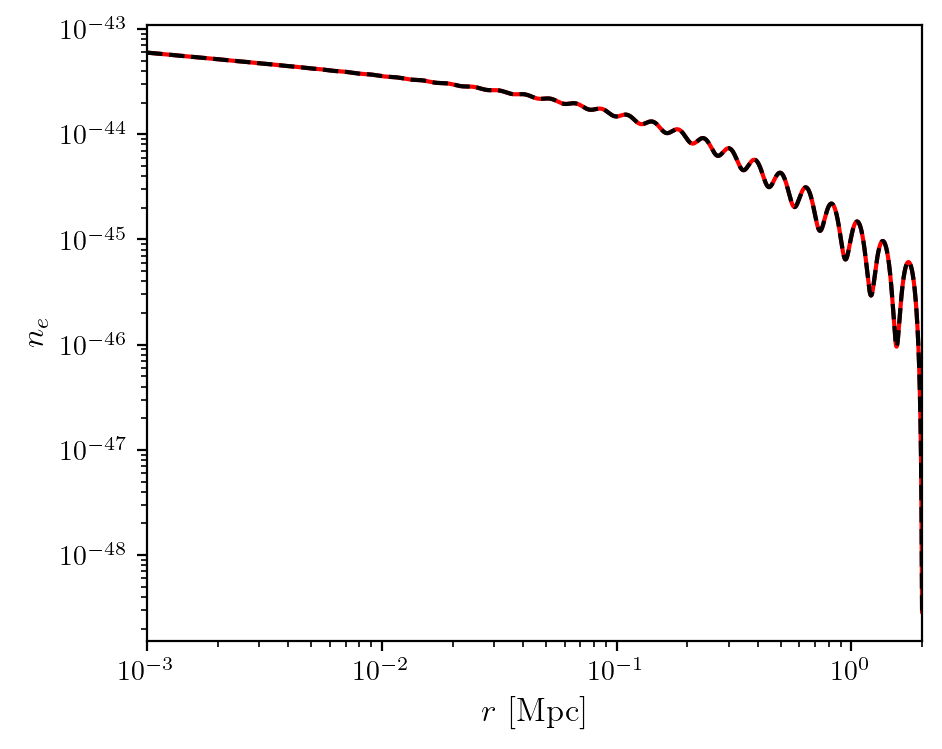

In [59]:
# n_er interp vs not_interp

plt.figure(figsize=(5,4))
plt.plot(r_thr, n_er_iterp(r_thr), color='r')
plt.plot(r_thr, n_er_not_int, color='k', ls='--')
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-3, 2)
plt.xlabel(r"$r~[{\rm Mpc}]$", fontsize=12)
plt.ylabel(r"$n_e$", fontsize=12)
plt.show()

In [60]:
########################################
# Specify functions Delta_a and Delta_parallel wrt r
########################################

#Note: we decided to work with \Delta_a and \Delta_\parallel defined without the minus sign. It is totally equivalent and the solution does not change.

def Delta_ar(r):
    """
    Axion mass term
    Delta_a = -m_a^2/(2*omega)
    """
    return m_a**2/(2*omega) 

def m2_gr(r):
    """
    Effective mass of the photon
    acquired by scattering with free electrons
    """
    return   ElementaryCharge**2 * 1/mass_electron * n_er_iterp(r) #in eV units 


def Delta_parallelr(r):
    """
    Photon mass term
    Delta_parallel = -m^2_\gamma(z)/2\omega
    """
    return m2_gr(r) /(2* omega)

def delta_m2(z):
    """
    Differences between Delta_\parallel and Delta_a
    """
    return ( m2_g(z)-m_a**2)/(2*omega)

In [61]:
#########################
# Searching for r_res
#########################

def resonance_condition(r):
    return Delta_parallelr(r) - Delta_ar(r)

# Is there a resonance point?
signs = np.sign(resonance_condition(r_thr))
sign_change_indices = np.where(np.diff(signs))[0]
if len(sign_change_indices) == 0:
    raise RuntimeError("No sign change found: resonance does not occur in this interval.")

#Using the Brent's method to find the root in the interval where the sign changes
i = sign_change_indices[0]
r_low, r_high = r_thr[i], r_thr[i+1]
r_res = brentq(resonance_condition, r_low, r_high)

print(f"Resonance radius found: r_res = {r_res} Mpc")

Resonance radius found: r_res = 0.5573768795807645 Mpc


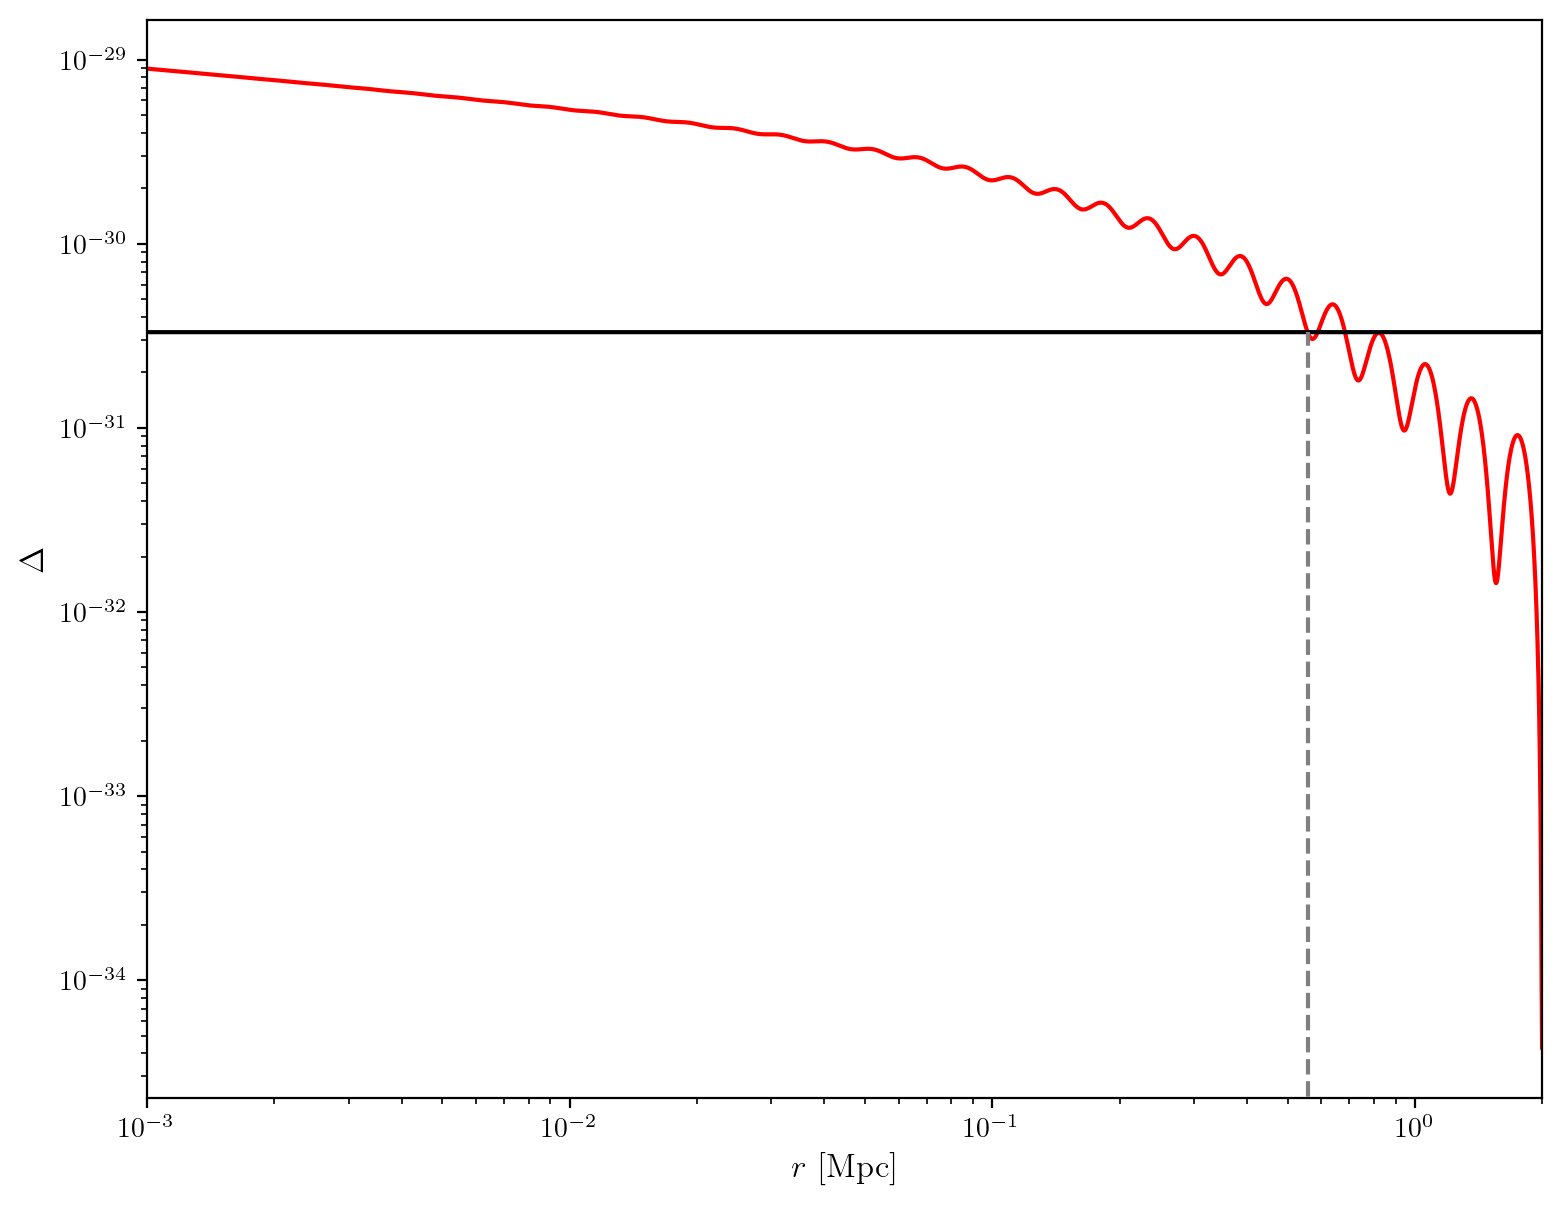

In [62]:
# Delta_parallel(r) vs Delta_a(r)


plt.plot(r_thr, Delta_parallelr(r_thr), color='r')
plt.plot(r_thr, Delta_ar(r_thr)*np.ones_like(r_thr), color='k')
r_res_line = plt.vlines(r_res, 0, Delta_ar(r_res), linestyle='dashed', color='gray', label=r'$z_n$')
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-3, 2)
plt.xlabel(r"$r~[{\rm Mpc}]$", fontsize=12)
plt.ylabel(r"$\Delta$", fontsize=12)
plt.show()

In [63]:
########################################
# Specify the halo model
########################################

# Halo setting 

chord_lenght = 2*np.sqrt(rvir**2 - rmin**2)
phii  = np.arcsin(rmin / rvir) 

In [64]:
########################################
# Mapping the halo model on the chord and setting the interval of integration
########################################

z_num      = 5000001 #steps number
z_num_half = 2500001



r_val_on_trj_pt1 = np.linspace(rvir, rmin, z_num_half) #First half-set of r values on the chord defined by the trajectory 
r_val_on_trj_pt2 = np.linspace(rmin, rvir, z_num_half) #Second half-set of r values on the chord defined by the trajectory 
r_val_on_trj = np.concatenate([r_val_on_trj_pt1[:], r_val_on_trj_pt2[1:] ]) #concatenating the two sets

z_chord = np.sqrt(r_val_on_trj**2 - rmin**2)

z_thr =np.zeros_like(r_val_on_trj)  # Interval of integration, here it is in Mpc because the Battaglia profile is computed in such a way.
                                    #Later, we need to switch in units of Delta_ag Mpc because the solver works with that units.

for i in range(z_num):
    if i < z_num_half:
        z_thr[i] = -z_chord[i]+chord_lenght/2 #In the case you want the interval between -chord_lenght/2 and +chord_lenght/2, cancel chord_lenght/2 in the eqn
    else:
        z_thr[i] = z_chord[i]+chord_lenght/2

z_0 =  z_thr[np.argmin(np.abs(z_thr - 1))]   #Just a pivotal scale in Mpc. Set to 1 for convenience
print("z_0 = ",z_0 )
    
#Here we associate the values of ne(r_val_on_trj) with the value of z_chord

ne_values_chord = n_er_iterp(r_val_on_trj)

#n_e = interp1d(z_thr, ne_values_chord, kind='linear', bounds_error=False, fill_value="extrapolate")


from numba import njit
import numpy as np

z_vals = z_thr.copy()
ne_vals = ne_values_chord.copy()

@njit
def n_e(z, z_vals, ne_vals):
    return np.interp(z, z_vals, ne_vals) #LOG INTEPROLATOR? 

z_0 =  1.0000002992501815


In [65]:
########################################
# Specify functions of the model in the case of constant magnetic field and linear electron numerical density
########################################

def Delta_a(z):
    """
    Axion mass term
    Delta_a = -m_a^2/(2*omega)
    """
    return m_a**2/(2*omega) 

Delta_a_value =  Delta_a(0)
Delta_a_vals = Delta_a_value * np.ones_like(z_thr)  


@njit
def m2_g(z, z_vals, ne_vals):
    """
    Effective mass of the photon
    acquired by scattering with free electrons
    """
    return ElementaryCharge**2 / mass_electron * n_e(z, z_vals, ne_vals)

m2_g_vals = np.array([m2_g(z, z_vals, ne_vals) for z in z_thr])


def B_T(z):
    """
    Transverse magnetic field
    """
    return  1 * 1e-6 * Gauss  #in \mu G 



@njit
def Delta_parallel(z, z_vals, ne_vals):
    """
    Photon mass term
    Delta_parallel = -m^2_\gamma(z)/2\omega
    """
    return m2_g(z, z_vals, ne_vals) / (2 * omega)

Delta_parallel_vals = np.array([Delta_parallel(z, z_vals, ne_vals) for z in z_thr])



if dark_photon:
    def Delta_ag(z):
        return eps*Delta_a(z)
else:
    def Delta_ag(z):
        """
        Axion-photon coupling term
        Delta_{a\gamma} = g_{a\gamma\gamma}/2 B_T(z)
        """
        return g_agg/2 * B_T(z)
    
Delta_ag_value = Delta_ag(0)
Delta_ag_vals =  Delta_ag_value * np.ones_like(z_thr)  

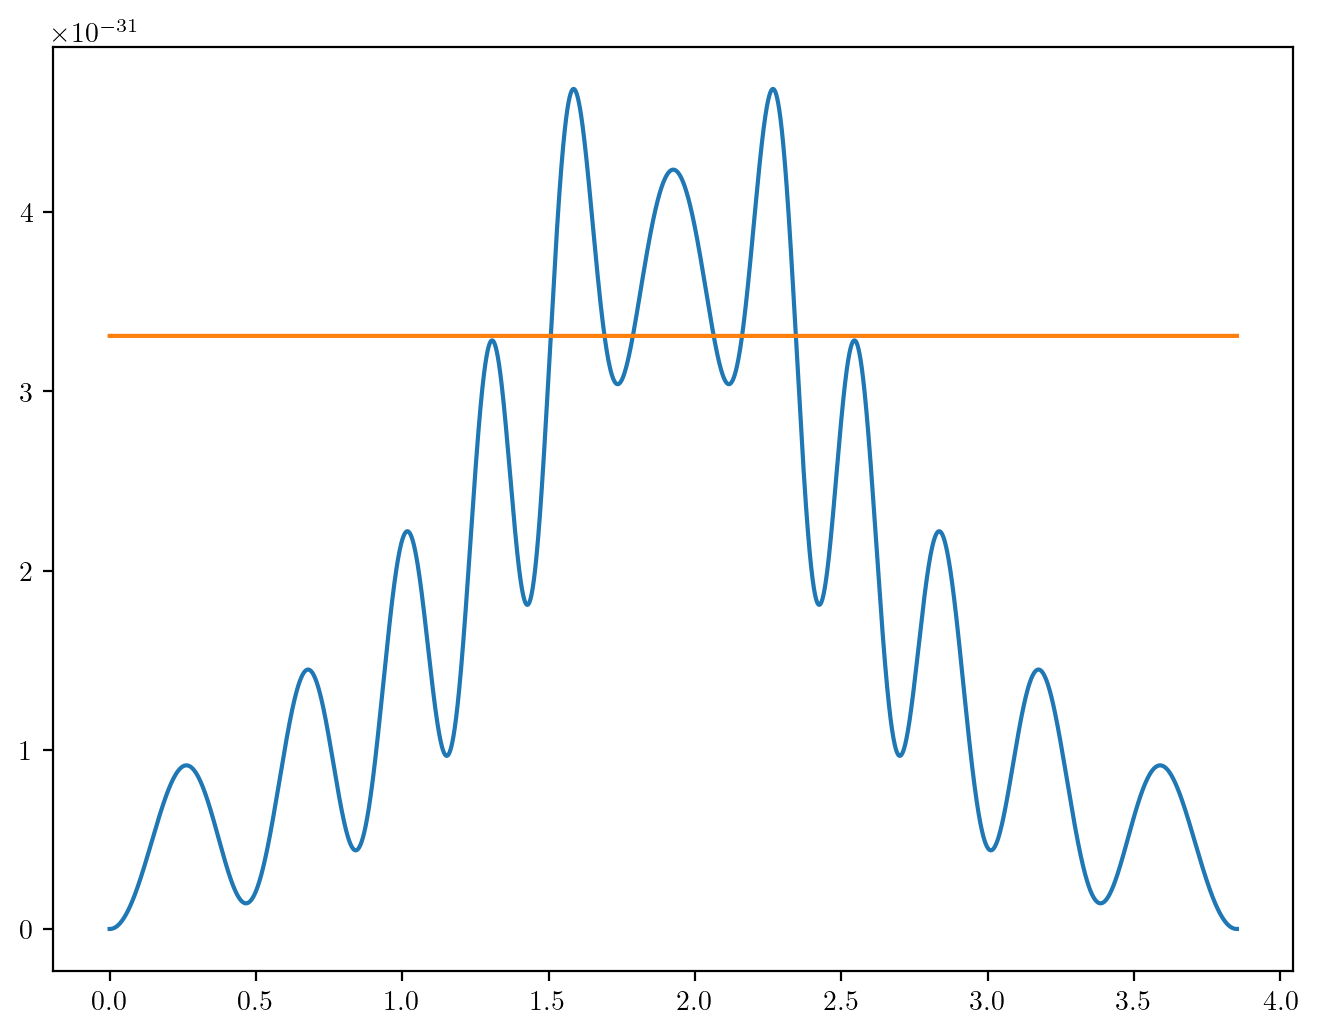

In [66]:
#Pre-plot to check if resonance happens in this conf.

plt.figure(figsize=(8,6))
plt.plot(z_thr, Delta_parallel_vals, label=r"$\Delta_\parallel(z)$")
plt.plot(z_thr, Delta_a_value * np.ones_like(z_thr), '-', label=r"$\Delta_a$ (costante)")

In [67]:
# Indeces and values at first and second resonance, and at the critical point . USE SCIPY TO FIND IT TO ECTEND THE CODE TO MULTIPLE RESONANCES

epsilon = 1e-100
relative_diff = np.abs(Delta_parallel_vals - Delta_a_vals) / (np.abs(Delta_parallel_vals) + np.abs(Delta_a_vals)  + epsilon) #Checking the relative difference would be finest
indices = np.where(relative_diff < 1e-5)[0]
indices

index_res1 = indices[0]
index_res2 = indices[-1]
index_crit = int(indices[0] + (indices[-1]-indices[0])/2)

z_res1 = z_thr[index_res1]
z_res2 = z_thr[index_res2]
z_crit = z_thr[index_res1]+ (z_thr[index_res2]-z_thr[index_res1])/2


In [68]:
z_res1

np.float64(1.5070218304161993)

In [69]:
z_res2

np.float64(2.3444194582444493)

In [70]:
#Actually, the first and second resonance can be found as follow, but in this case we need to have a precise r_res  

z_res1_test = chord_lenght/2 -np.sqrt(r_res**2-rmin**2)
z_res2_test = chord_lenght/2 +np.sqrt(r_res**2-rmin**2)
print(z_res1_test)
print(z_res2_test)

1.787630145413165
2.063811143247484


In [71]:
########################################
# Test: Are the two points of resonance mapped properly?
########################################

print('Resonance point 1=', z_res1)
print('The resonance happens at a distance d=', np.sqrt(r_res**2-rmin**2), 'from the center of the chord. Then d+z1=', np.sqrt(r_res**2-rmin**2)+z_res1, 'needs to be circa equal to chord_lenght/2:', chord_lenght/2  )
print('Resonance point 2=', z_res2)
print('The resonance happens at a distance d=', np.sqrt(r_res**2-rmin**2), 'from the center of the chord. Then z2-d=', -np.sqrt(r_res**2-rmin**2)+z_res2, 'needs to be circa equal to chord_lenght/2:', chord_lenght/2  )



Resonance point 1= 1.5070218304161993
The resonance happens at a distance d= 0.13809049891715958 from the center of the chord. Then d+z1= 1.645112329333359 needs to be circa equal to chord_lenght/2: 1.9257206443303245
Resonance point 2= 2.3444194582444493
The resonance happens at a distance d= 0.13809049891715958 from the center of the chord. Then z2-d= 2.2063289593272897 needs to be circa equal to chord_lenght/2: 1.9257206443303245


In [72]:
#Computing the derivative of Delta_parallel and the factor gamma. 

dDelta_parallel = np.abs(np.gradient(Delta_parallel_vals, z_thr)) /(Mpc) #Recall here we are still working in Mpc units. 

gamma_factor = (Delta_ag_value)**2/(dDelta_parallel)
print('gamma at first res = ', gamma_factor[index_res1])
print('gamma at second res =' , gamma_factor[index_res2])
print('gamma at critical point =' , gamma_factor[index_crit])

gamma at first res =  5.09461174057547e-05
gamma at second res = 5.09461174069571e-05
gamma at critical point = 3315624619.440836


In [73]:
#Computing the probability à la C. Mondino, and comparing it with 2\pi\gamma

log = np.log(m2_g_vals)
derivative = np.abs(np.gradient(log, z_thr))**-1

if dark_photon:
    prob_Mondino  = (np.pi * eps**2 * m_a**2/omega ) * derivative[index_res1] * Mpc #Here the resonance happens at z_shift, then you need the index of it
else:
    prob_Mondino  = omega * np.pi * g_agg**2 * B_T(z_thr[index_res1])**2 / m_a**2 * derivative[index_res1] * Mpc #Here the resonance happens at z_shift, then you need the index of it

print("2*pi*gamma is",  2*np.pi*gamma_factor[index_res1])
print("Mondino's probability is",  prob_Mondino)

2*pi*gamma is 0.0003201038963416841
Mondino's probability is 0.0003200975198016686


/var/folders/jc/kky54qz15j50ck9_kzrzk_d80000gn/T/ipykernel_67443/1978949294.py:4: RuntimeWarning: divide by zero encountered in reciprocal
  derivative = np.abs(np.gradient(log, z_thr))**-1


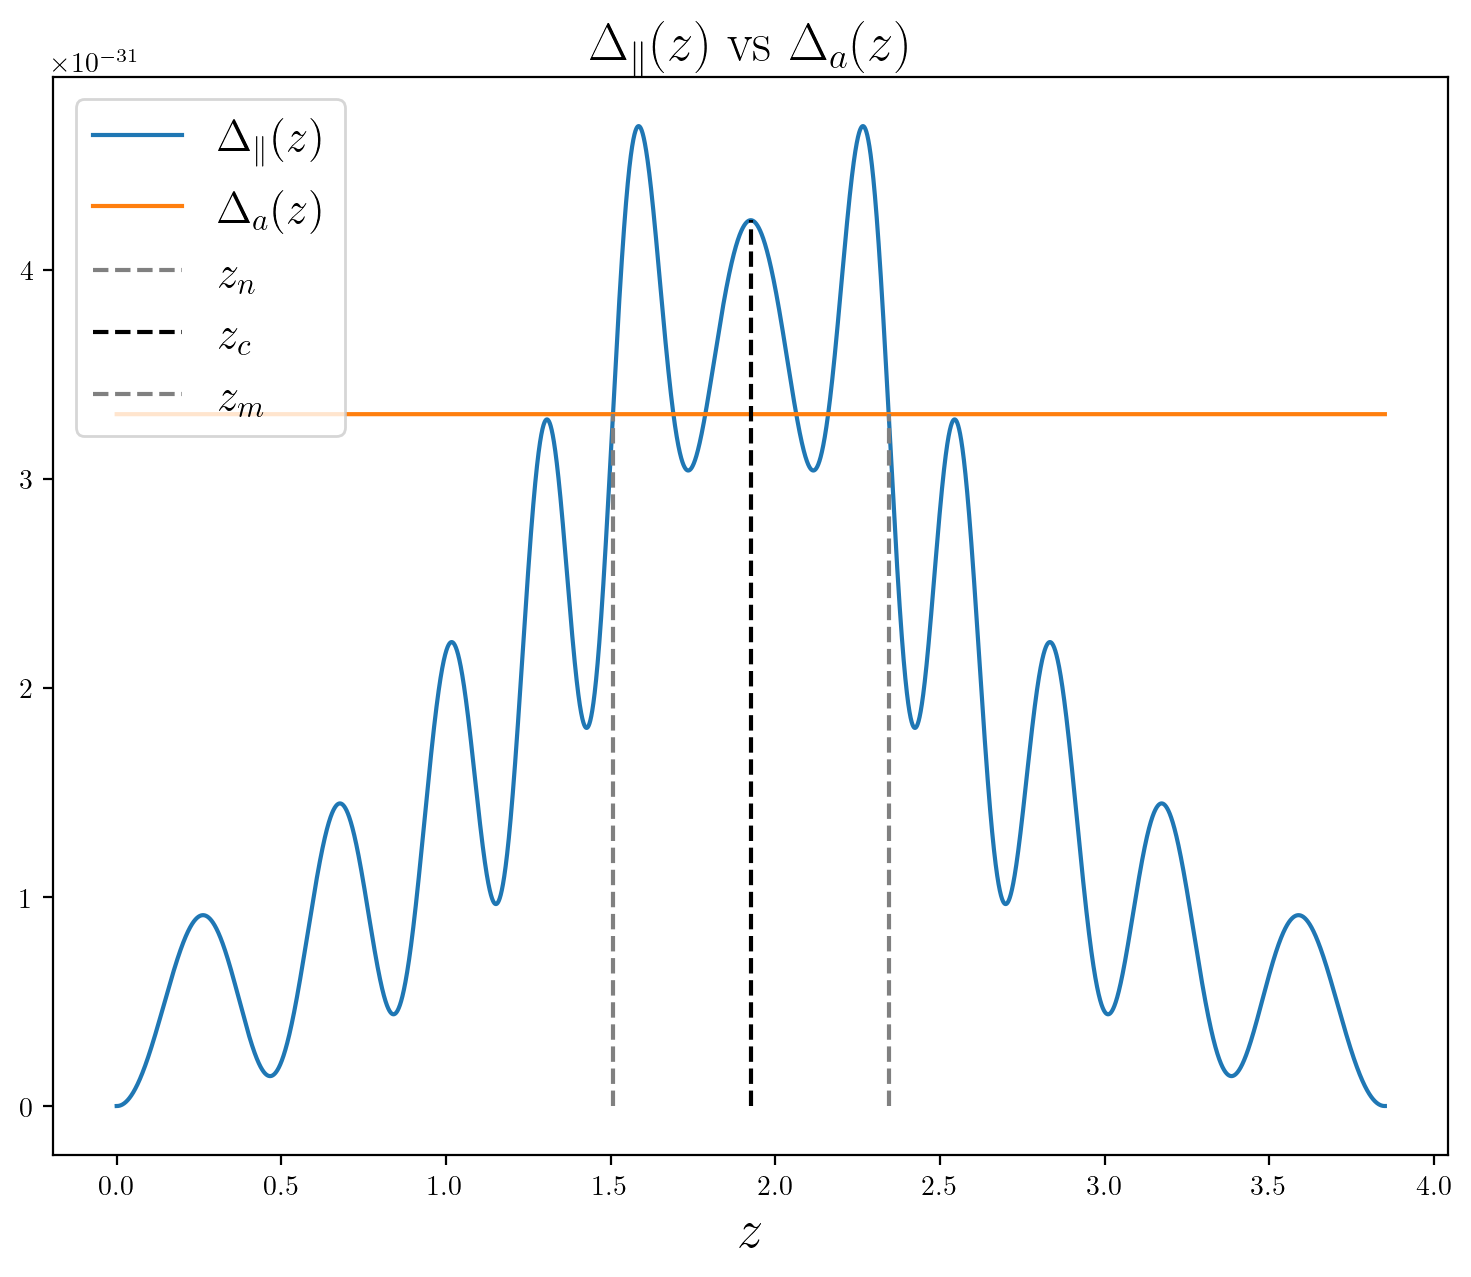

In [74]:
#Plotting Delta_parallel and Delta_a to check where resonance happens. 

plt.plot(z_thr, Delta_parallel_vals, label=r'$\Delta_\parallel(z)$')
plt.plot(z_thr, Delta_a_vals, label=r'$\Delta_a(z)$')

z_n_line = plt.vlines(z_res1, 0, Delta_a_value, linestyle='dashed', color='gray', label=r'$z_n$')
z_c_line = plt.vlines(z_crit, 0, Delta_parallel_vals[index_crit], linestyle='dashed', color='black', label=r'$z_c$')
z_m_line = plt.vlines(z_res2, 0, Delta_a_value, linestyle='dashed', color='gray', label=r'$z_m$')

plt.title(r'$\Delta_\parallel(z)$ vs $\Delta_a(z)$', fontsize=19)
plt.xlabel(r'$z$', fontsize=19)

plt.legend(fontsize=16, loc='upper left')

plt.show()

229.8057589201662
357.50052318769605


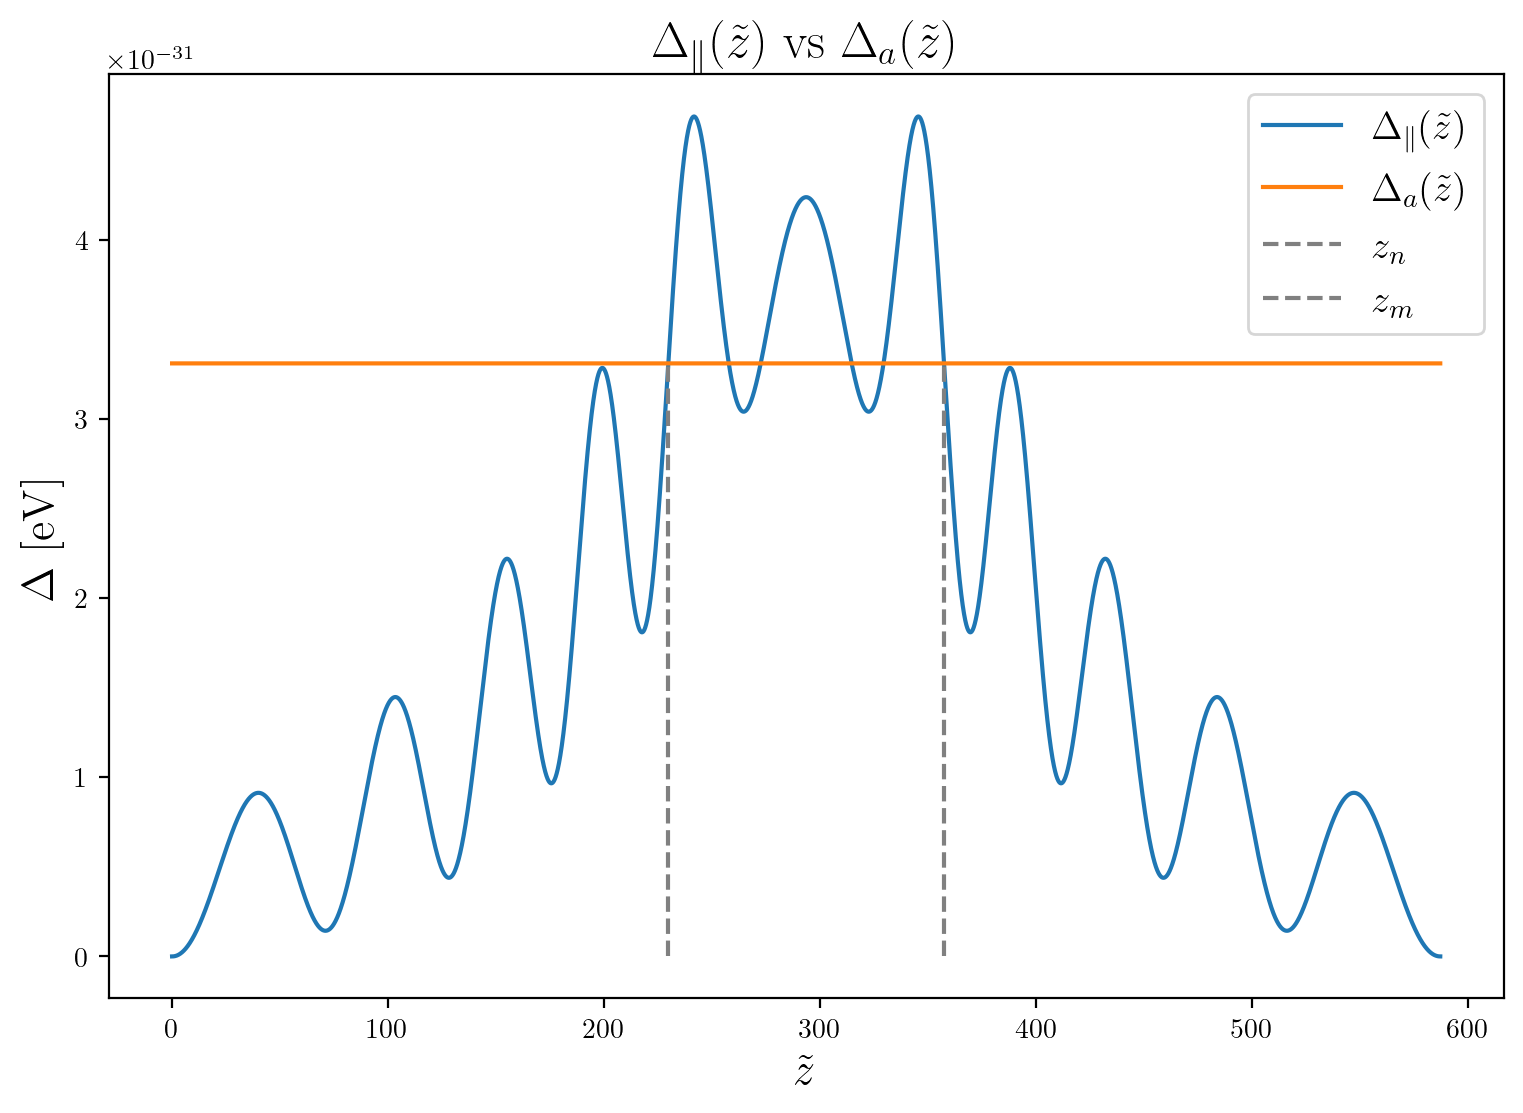

In [75]:
# Conversion from z_thr in Mpc to tilde{z}, because both the Battaglia profile and the mapping were computed in units of Mpc


z_tilde_thr = Delta_ag_vals * Mpc * z_thr

@njit
def Delta_parallel_tilde(zt, Delta_ag_val, z_vals, ne_vals):
    z_phys = zt / (Delta_ag_val * Mpc)
    return Delta_parallel(z_phys, z_vals, ne_vals)

Delta_parallel_tilde_vals = np.array([Delta_parallel_tilde(z, Delta_ag_value, z_vals, ne_vals) for z in z_tilde_thr])

z_tilde_res1 = Delta_ag_value * Mpc * z_res1
z_tilde_res2 = Delta_ag_value * Mpc * z_res2
print(z_tilde_res1)
print(z_tilde_res2)


# Plotting Delta_parallel(z_tilde) and Delta_a(z_tilde)
plt.figure(figsize=(9, 6))
plt.plot(z_tilde_thr, Delta_parallel_tilde_vals, label=r"$\Delta_\parallel(\tilde{z})$")
plt.plot(z_tilde_thr, Delta_a_vals, label=r"$\Delta_a(\tilde{z})$")
z_tilde_n_line = plt.vlines(z_tilde_res1, 0, Delta_a_value, linestyle='dashed', color='gray', label=r'$z_n$')
z_tilde_m_line = plt.vlines(z_tilde_res2, 0, Delta_a_value, linestyle='dashed', color='gray', label=r'$z_m$')

plt.xlabel(r"$\tilde{z}$", fontsize=16)
plt.ylabel(r"$\Delta~[\mathrm{eV}]$", fontsize=16)
plt.title(r"$\Delta_\parallel(\tilde{z})$ vs $\Delta_a(\tilde{z})$", fontsize=18)
plt.legend(fontsize=14)
plt.show()

In [76]:
#Computing the derivative of Delta_parallel and the factor gamma in units of Delta_ag Mpc

dDelta_parallel_tilde = np.abs(np.gradient(Delta_parallel_tilde_vals, z_tilde_thr ))

gamma_factor_tilde = (Delta_ag_value)/(dDelta_parallel_tilde)
print('gamma at first res = ', gamma_factor_tilde[index_res1])
print('gamma at second res =' , gamma_factor_tilde[index_res2])
print('gamma at critical point =' , gamma_factor_tilde[index_crit])

gamma at first res =  5.094611740664283e-05
gamma at second res = 5.094611740712031e-05
gamma at critical point = inf


/var/folders/jc/kky54qz15j50ck9_kzrzk_d80000gn/T/ipykernel_67443/128796486.py:5: RuntimeWarning: divide by zero encountered in divide
  gamma_factor_tilde = (Delta_ag_value)/(dDelta_parallel_tilde)


In [77]:
#Defining the solver for the photon-to-axion equation


@njit
def master_eq_LZ_1_numba(z, S, z_tilde_vals, Delta_parallel_tilde_vals, Delta_a_val, Delta_ag_val):
    ax, f = S[0], S[1]

    # Interpolation of Delta_parallel_tilde
    Delta_parallel_tilde_interp = np.interp(z, z_tilde_vals, Delta_parallel_tilde_vals)

    dSdz_0 = f
    dSdz_1 = -1j * (Delta_parallel_tilde_interp - Delta_a_val) / Delta_ag_val * f - ax

    return np.array([dSdz_0, dSdz_1], dtype=np.complex128)

#Initial values
z_init = z_tilde_thr[0]
ic_LZ = np.array([ 0, -1j ], dtype=np.complex128)


In [78]:
#In the case we want to integrate the equation in a shorter interval 

#MAKE ALL THE PARAMETERS VARIABLES

cut = True

if cut: 
    z_tilde_thr_cut =np.linspace(z_tilde_res1-2,z_tilde_res2+7, 10000 )
else:
    z_tilde_thr_cut = z_tilde_thr
    
#Interpolating Delta_parallel_tilde over z_tilde_thr_cut (wheter or not there is a cut)
Delta_parallel_tilde_cut_interp = np.interp(z_tilde_thr_cut, z_tilde_thr, Delta_parallel_tilde_vals)

In [79]:
z_tilde_thr_cut    

array([227.80575892, 227.81942976, 227.83310061, ..., 364.4731815 ,
       364.48685234, 364.50052319])

In [81]:
#Solving the equation on z_tilde_thr_cut 

# Wrapper to be compatible with solve_ivp
def wrapper_master_eq(z, S):
    return master_eq_LZ_1_numba(
        z,
        S,
        z_tilde_thr_cut,
        Delta_parallel_tilde_cut_interp,
        Delta_a_value,
        Delta_ag_value
    )


computed = True

if computed:
    # Load precomputed probability if available
    p_LZ_1_increasing_decreasing = np.loadtxt('probability_Battaglia_numba_multres.txt')
else:
    # Solve the ODE using the fast Numba-compatible wrapper
    sol_LZ_1_increasing_decreasing = solve_ivp(
        wrapper_master_eq,
        (z_tilde_thr_cut[0], z_tilde_thr_cut[-1]),
        ic_LZ,
        method='DOP853',
        t_eval=z_tilde_thr_cut,
        rtol=1e-10,
        atol=1e-12
    )

    # Compute the probability from the axion amplitude
    p_LZ_1_increasing_decreasing = np.abs(sol_LZ_1_increasing_decreasing.y[0])**2

    # Save the result
    np.savetxt('probability_Battaglia_numba_multres.txt', p_LZ_1_increasing_decreasing)

In [82]:
#Averaging the probability from the second resonance point on, in order to obtain a mean value: 

index_res1_cut = np.argmin(np.abs(z_tilde_thr_cut - z_tilde_thr[index_res1]))
index_res2_cut = np.argmin(np.abs(z_tilde_thr_cut - z_tilde_thr[index_res2]))

P_mean_value_2nd_res = np.average(p_LZ_1_increasing_decreasing[index_res2_cut: ])
print(P_mean_value_2nd_res)
print(P_mean_value_2nd_res/(8*np.pi*gamma_factor[index_res1]))

0.006459323395776778
5.0447085068296005


In [83]:
0.1361342909914965
0.5399429297649827

0.5399429297649827

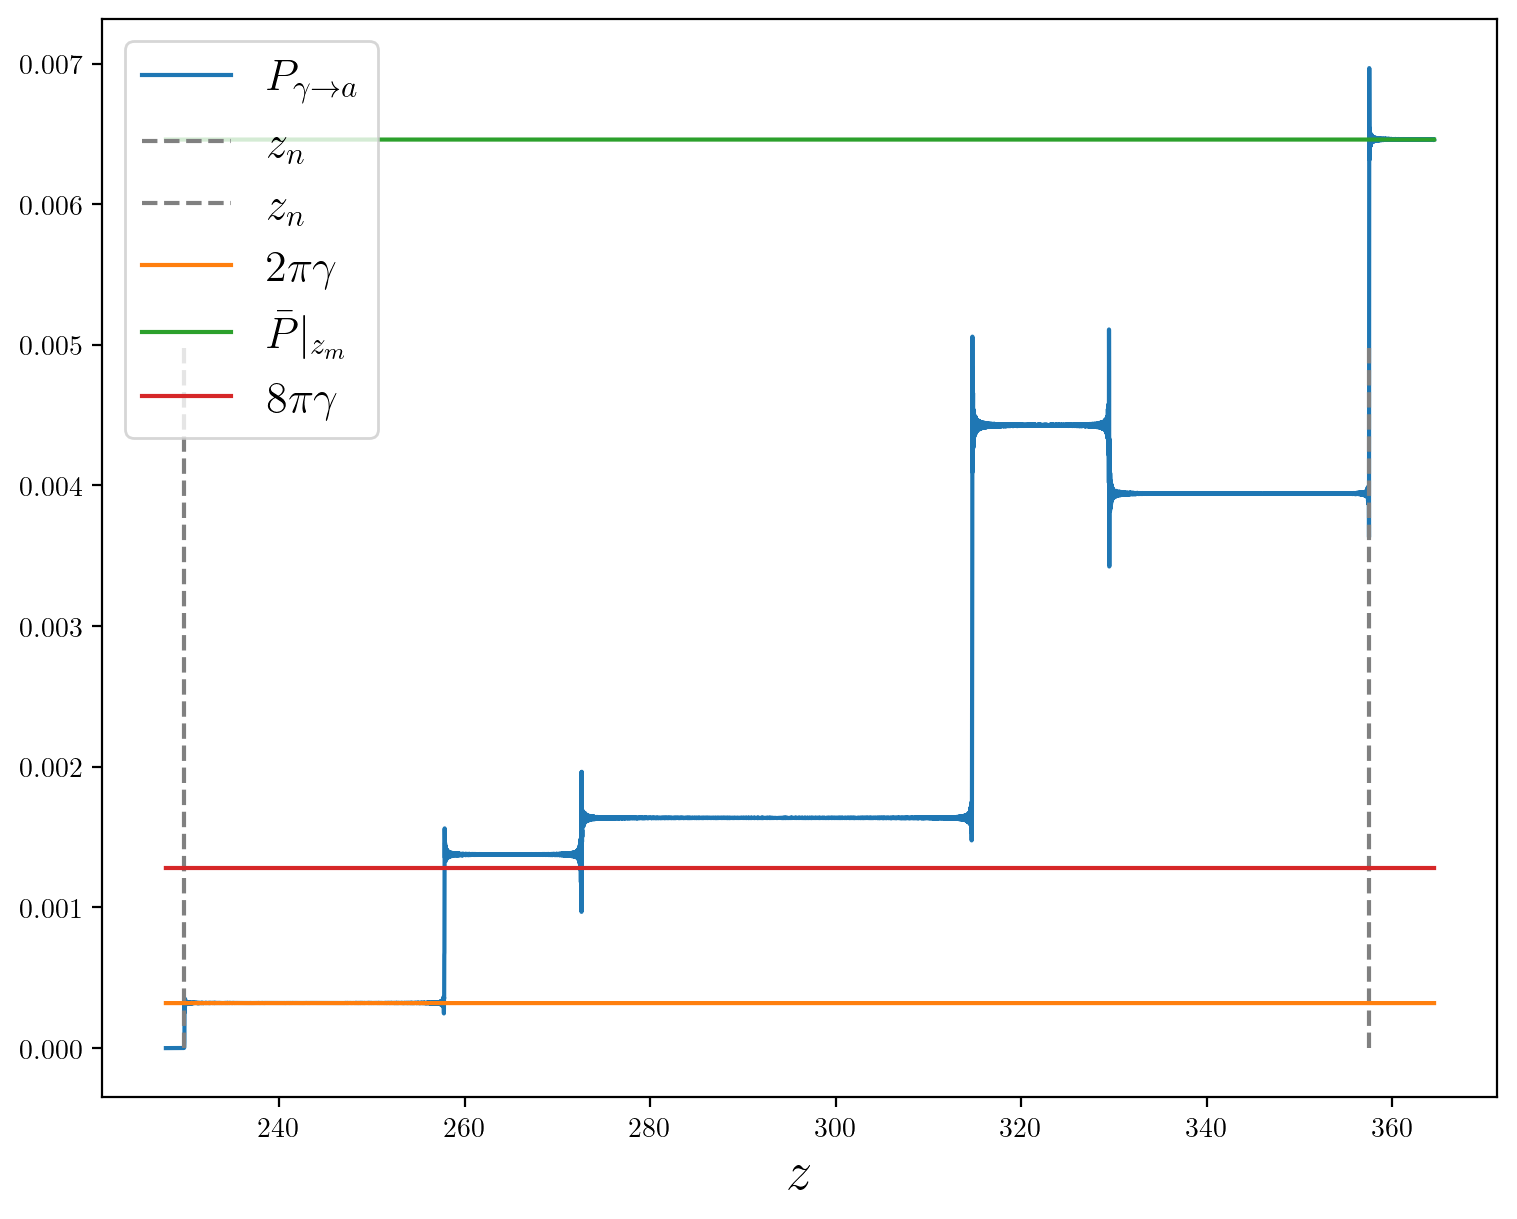

In [84]:
#Plotting the solution

plt.plot(z_tilde_thr_cut, p_LZ_1_increasing_decreasing, label=r'$P_{\gamma \rightarrow a}$')
z_n_line = plt.vlines(z_tilde_thr_cut[index_res1_cut], 0,0.005, linestyle='dashed', color='gray', label=r'$z_n$')
z_n_line = plt.vlines(z_tilde_thr_cut[index_res2_cut], 0,0.005, linestyle='dashed', color='gray', label=r'$z_n$')
plt.plot(z_tilde_thr_cut, 2*np.pi*gamma_factor_tilde[index_res1]*np.ones_like((z_tilde_thr_cut)), label=r'$2\pi\gamma$')
plt.plot(z_tilde_thr_cut,P_mean_value_2nd_res*np.ones_like(z_tilde_thr_cut), label=r'$\bar{P}|_{z_m}$')
plt.plot(z_tilde_thr_cut, 8*np.pi*gamma_factor_tilde[index_res1]*np.ones_like((z_tilde_thr_cut)), label=r'$8\pi\gamma$')
plt.xlabel(r'$z$', fontsize=19)
plt.legend(fontsize=16, loc='upper left')

For multiple resonance cases there are Quantum Mechanics effect of interference between the waves. In the paper by Brahma et al. (https://arxiv.org/abs/2308.08586) these phase effects are studied. 
The proposed equation for multiple level crossing is

$ P_{\gamma \mapsto a} = \sum_n (2\pi \gamma_n) + 2 \sum_{n<m} \sqrt{(2\pi\gamma_n) (2\pi \gamma_m) } \cos{\Phi_{nm}} $, 

where $\Phi_{nm}$ is a certain phase: 

$\Phi_{nm} = \Phi(z_n) - \Phi(z_m) +\frac{\pi}{4} (\sigma_n-\sigma_m)$

where $\Phi(z)$ is defined to be

$\Phi(z) = \int_{z_i}^{z} (\Delta_\parallel(z) - \Delta_a) dz = \int_{\tilde{z}_i}^{\tilde{z}} d\tilde{z}'_A \, \frac{\Delta_\parallel(\tilde{z}') - \Delta_a}{\Delta_{a\gamma}}$

and

$\sigma(z) = \text{sign}\left[\Phi''(z)\right] = \text{sign}\left[\Delta'_\parallel(z)\right]$.

For two resonance points and in our case of linear increasing-decreasing we have

$\Phi_{nm} = \int_{z_m}^{z_n} \ (\Delta_\parallel(z) -\Delta_a) dz -\frac{\pi}{2} = \frac{1}{2} 2\bar{z} \frac{\Delta_a}{z_0} \bar{z} -\frac{\pi}{2}$.

From the probability equation, being $\cos{\Phi_{nm}}$ maximum in 1, minumum in -1 and on average 0 we get that, in our case of two resonance points ($n=1,2$) where $\gamma_n = \gamma_m$: 

1) Maximum at: $2\pi\gamma (1+1+2) = 4 (2\pi\gamma)$

2) Mean at: $2\pi\gamma (1+1+0) = 2 (2\pi\gamma)$

3) Minum at: $2\pi\gamma (1+1-2) = 0$


In [85]:
from scipy.integrate import quad



def Delta_parallel_minus_Delta_a_tilde(zt):
    Delta_parallel_val = np.interp(zt, z_tilde_thr, Delta_parallel_tilde_vals)
    return Delta_parallel_val - Delta_a_value

integral, error = quad(Delta_parallel_minus_Delta_a_tilde, z_tilde_res2, z_tilde_res1) # Integrating Delta_\parallel - Delta_a from z_res1 to z_res2
area = (-1) / Delta_ag_value * integral #Renormalized integral by 1/(Delta_ag(z_res1)), as we did for the ODE solver.

phi_nm = area - np.pi / 2 #Computing the phase
factor = 1 + 1 + 2 * np.cos(phi_nm)  # P = 2πγ × factor

print(f"Area = {area}, estimated error: {error}")
print(f"Phi_nm = {phi_nm}")
print(f"Probability factor = {factor}")
print(f"Area / (2π) = {area / (2 * np.pi)}")

Area = 6760596.375684325, estimated error: 3.258401550322685e-33
Phi_nm = 6760594.804887998
Probability factor = 3.7438283637981513
Area / (2π) = 1075982.3314393125


In [86]:
#From the probability at the second resonance point we can compute the numerical \Phi_nm and the numerical factor 

numerical_phase = np.arccos( (P_mean_value_2nd_res - 4*np.pi*gamma_factor[index_res2])/(4*np.pi*gamma_factor[index_res2]) )
numerical_factor = 1+1+2*np.cos(numerical_phase)
print('Numerical prob factor = ', numerical_factor)

Numerical prob factor =  nan


/var/folders/jc/kky54qz15j50ck9_kzrzk_d80000gn/T/ipykernel_67443/1943828508.py:3: RuntimeWarning: invalid value encountered in arccos
  numerical_phase = np.arccos( (P_mean_value_2nd_res - 4*np.pi*gamma_factor[index_res2])/(4*np.pi*gamma_factor[index_res2]) )


In [138]:
error_2nd_prob = np.abs((numerical_factor-factor)/factor)
print('Error num vs ana = ', error_2nd_prob)

Error num vs ana =  0.23255411689089445


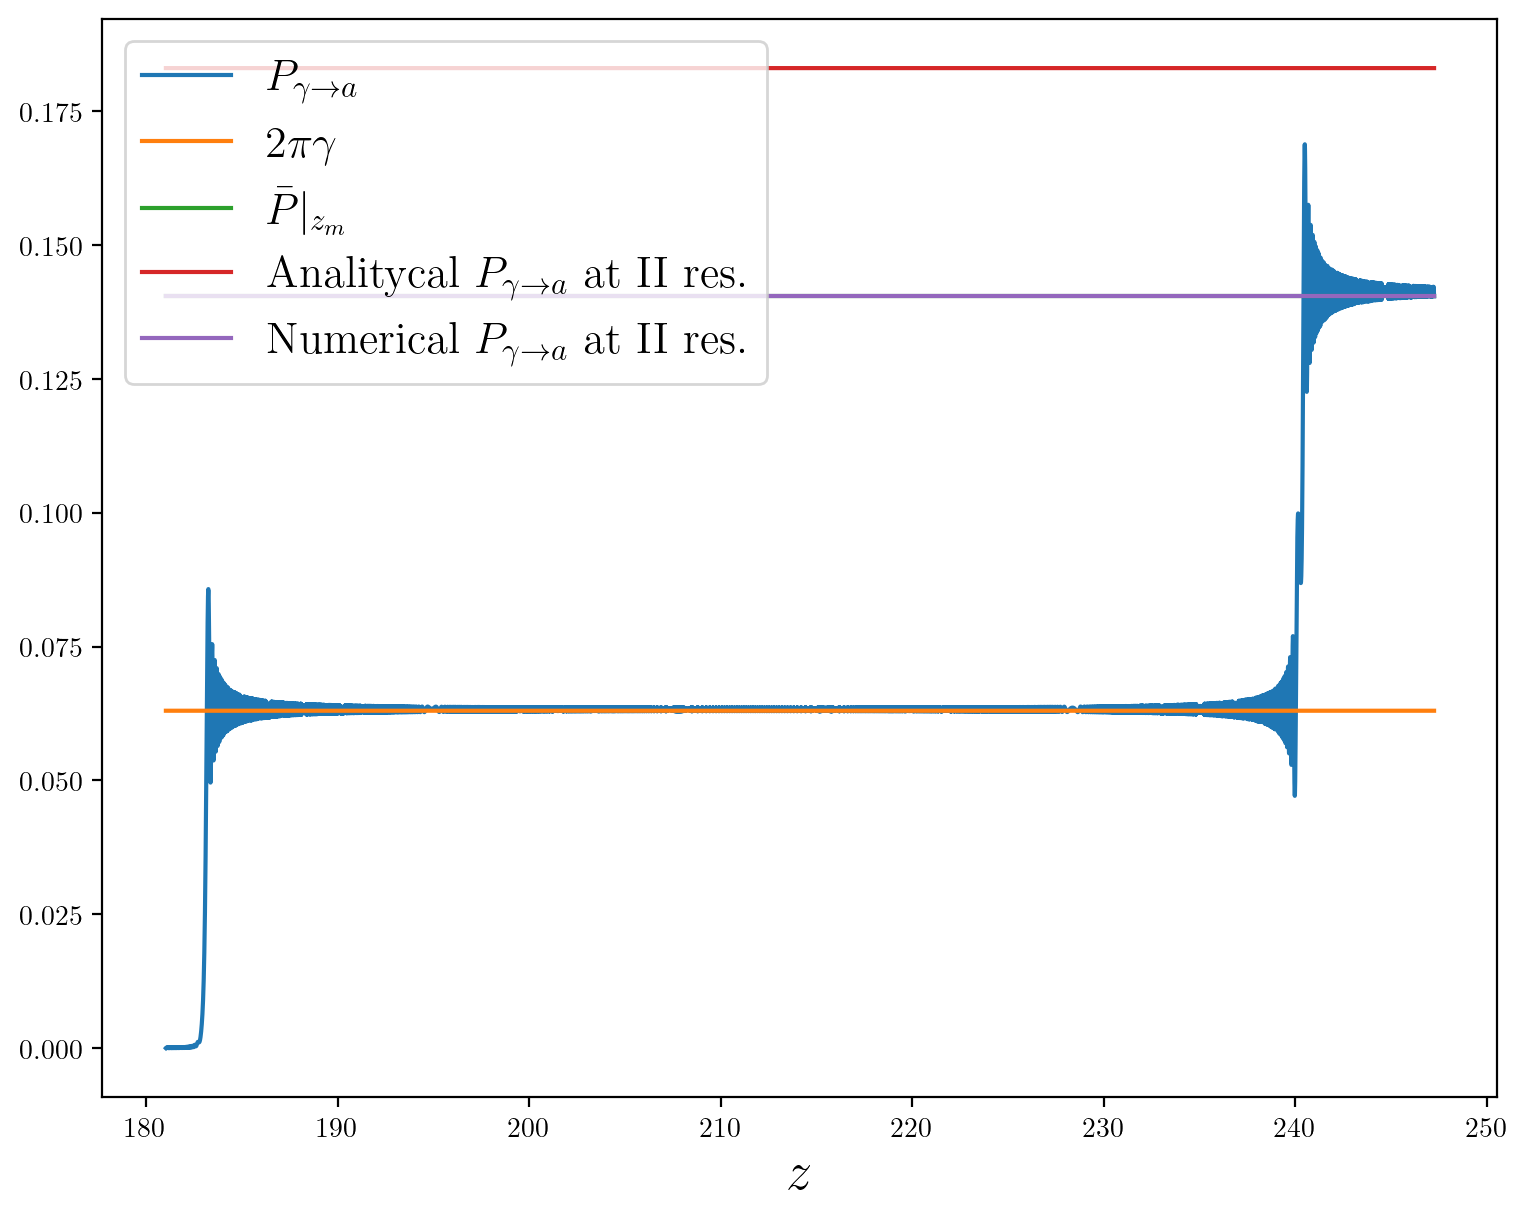

In [139]:
#Plotting the solution
plt.plot(z_tilde_thr_cut, p_LZ_1_increasing_decreasing, label=r'$P_{\gamma \rightarrow a}$')
plt.plot(z_tilde_thr_cut, 2*np.pi*gamma_factor[index_res1]*np.ones_like((z_tilde_thr_cut)), label=r'$2\pi\gamma$')
plt.plot(z_tilde_thr_cut,P_mean_value_2nd_res*np.ones_like(z_tilde_thr_cut), label=r'$\bar{P}|_{z_m}$')
plt.plot(z_tilde_thr_cut,2*np.pi*gamma_factor[index_res1]*np.ones_like(z_tilde_thr_cut) * factor, label=r'Analitycal $P_{\gamma \rightarrow a}$ at II res.') #Analytical probability at the second resonance point
plt.plot(z_tilde_thr_cut,2*np.pi*gamma_factor[index_res1]*np.ones_like(z_tilde_thr_cut) * numerical_factor, label=r'Numerical $P_{\gamma \rightarrow a}$ at II res.') #Numerical probability at the second resonance point
plt.xlabel(r'$z$', fontsize=19)
plt.legend(fontsize=16, loc='upper left')


[1.01564142e-06 1.01564169e-06 1.01564197e-06 ... 1.01564197e-06
 1.01564169e-06 1.01564142e-06]
[0.01403097 0.01412817 0.01422672 ... 0.00392703 0.00391912 0.00391124]


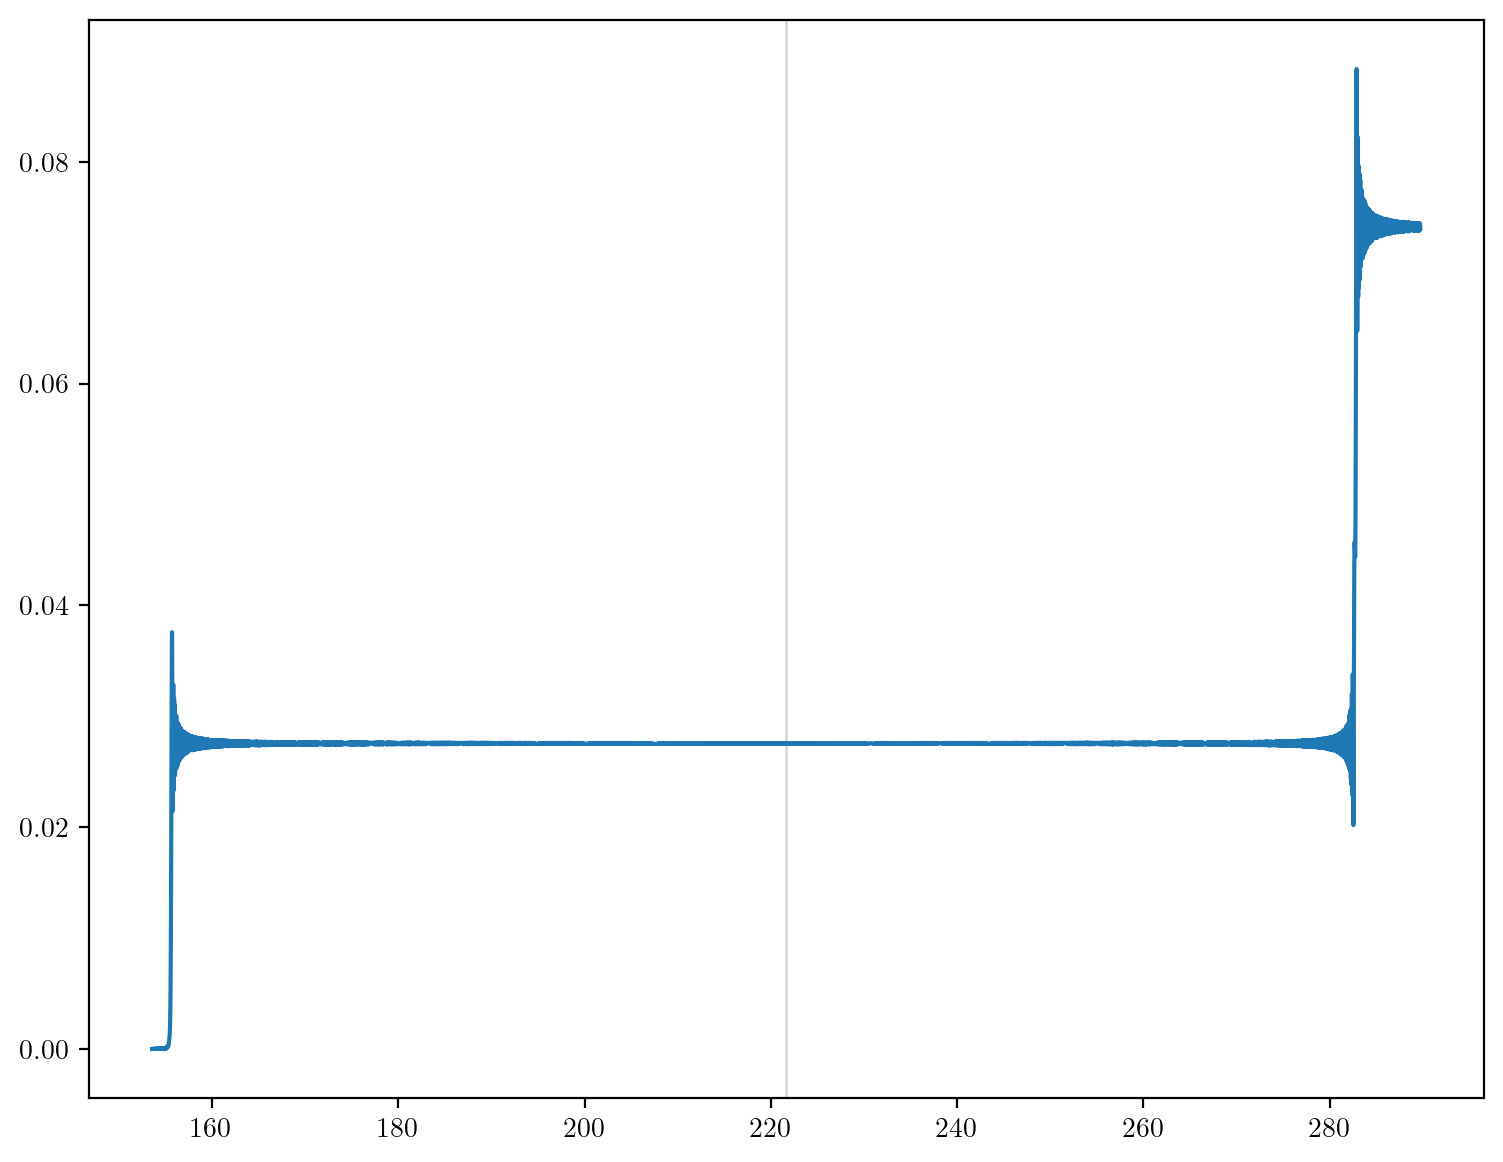

In [83]:
########################################
# On the oscillation lenght
########################################

l_osc = np.abs(2 * np.pi / (Delta_parallel_vals - Delta_a_value)) / Mpc
print(l_osc)
losc_tilde = np.abs(2 * np.pi / ((Delta_parallel_tilde_cut_interp - Delta_a_value) / Delta_ag_value))
print(losc_tilde)


plt.plot(z_tilde_thr_cut, p_LZ_1_increasing_decreasing, label=r'$P_{\gamma \rightarrow a}$')
plt.axvspan( z_tilde_thr_cut[5000],z_tilde_thr_cut[5000] + losc_tilde[5000], color='gray', alpha=0.3) 
#plt.xlim(169.97,169.975)
#plt.ylim(0.013,0.014)

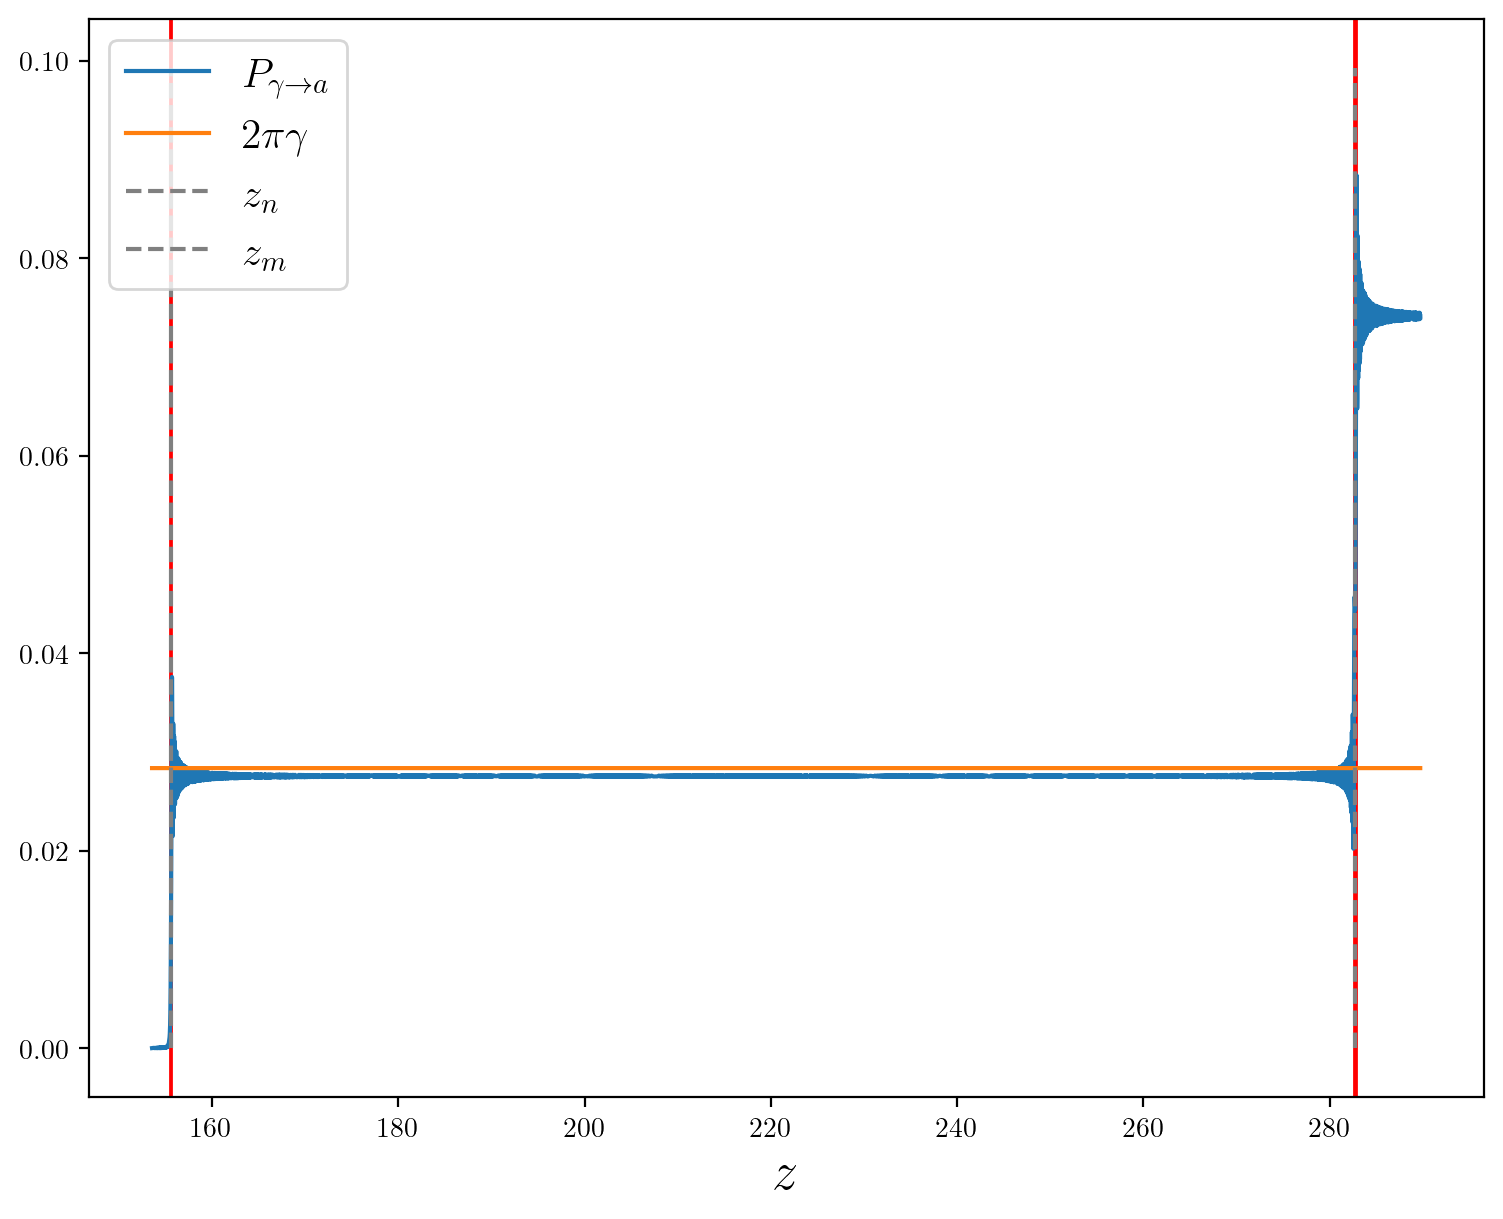

In [84]:
########################################
# On the resonance lenght
########################################

R_lenght = np.sqrt( 2*np.pi*gamma_factor[index_res1])/Delta_ag(z_thr[index_res1])
R_lenght_tilde =  np.sqrt( 2*np.pi*gamma_factor[index_res1])
R_lenght_tilde

#Plotting the solution
plt.plot(z_tilde_thr_cut, p_LZ_1_increasing_decreasing, label=r'$P_{\gamma \rightarrow a}$')
plt.axvspan( (z_tilde_thr_cut[index_res1_cut] - R_lenght_tilde/2).item(), (z_tilde_thr_cut[index_res1_cut] + R_lenght_tilde/2).item(), color='red', alpha=1) 
plt.axvspan( (z_tilde_thr_cut[index_res2_cut] - R_lenght_tilde/2).item(), (z_tilde_thr_cut[index_res2_cut] + R_lenght_tilde/2).item(), color='red', alpha=1) 
plt.plot(z_tilde_thr_cut, 2*np.pi*gamma_factor[index_res1]*np.ones_like(z_tilde_thr_cut), label=r'$2\pi\gamma$')

z_n_line = plt.vlines(z_tilde_thr_cut[index_res1_cut], 0,7*np.pi*gamma_factor[index_res1], linestyle='dashed', color='gray', label=r'$z_n$')
z_m_line = plt.vlines(z_tilde_thr_cut[index_res2_cut], 0, 7*np.pi*gamma_factor[index_res1], linestyle='dashed', color='gray', label=r'$z_m$')

plt.xlabel(r'$z$', fontsize=19)
plt.legend(fontsize=15, loc='upper left') 

In [85]:
#In the case we want to integrate the equation in a shorter interval 



z_tilde_thr_cut1 =np.linspace(z_tilde_res1-2,z_tilde_res1+7, 10000 )
    
Delta_parallel_tilde_cut_interp1 = np.interp(z_tilde_thr_cut1, z_tilde_thr, Delta_parallel_tilde_vals)





In [86]:
z_tilde_thr_cut1[-1]

np.float64(162.54093003541382)

In [87]:
losc_tilde1 = np.abs(2 * np.pi / ((Delta_parallel_tilde_cut_interp1 - Delta_a_value) / Delta_ag_value))
print(losc_tilde1)

[0.01403097 0.01403736 0.01404374 ... 0.0042171  0.00421658 0.00421606]


In [88]:
z_tilde_res2

np.float64(282.7312472120674)

In [89]:
2*z_num

10000002

In [100]:
import numpy as np
from scipy.integrate import cumulative_trapezoid

# ==========================
# Parametri da impostare
# ==========================

N = 1e5  # Numero di oscillazioni
z_1 = z_tilde_thr_cut1[-1]  # Fine del primo intervallo
phase_target = 2 * np.pi * N  # Sfasamento desiderato

# ==========================
# Dominio per la ricerca
# ==========================

# Griglia sufficientemente estesa a destra di z_1
z_grid = np.linspace(z_1, z_1 + 120, 10000002)

# ==========================
# Funzione da integrare
# ==========================

# Interpola Delta_parallel_tilde sul nuovo dominio
Delta_parallel_vals = np.interp(z_grid, z_tilde_thr, Delta_parallel_tilde_vals)

# Integrando della fase
integrand = (Delta_parallel_vals - Delta_a_value) / Delta_ag_value

# ==========================
# Fase accumulata Φ(z)
# ==========================

Phi_vals = cumulative_trapezoid(integrand, z_grid, initial=0)

# ==========================
# Ricerca di z_2
# ==========================

idx_target = np.argmin(np.abs(Phi_vals - phase_target))
z_2 = z_grid[idx_target]

print(f"Trovato z_2 ≈ {z_2:.10f}, con sfasamento ≈ {Phi_vals[idx_target]:.3f}")

Trovato z_2 ≈ 276.1606746734, con sfasamento ≈ 628318.536


In [101]:
z_tilde_thr_cut2_min =z_2

In [102]:

z_tilde_thr_cut2 =np.linspace(z_tilde_thr_cut2_min,z_tilde_res2+7, 10000 )
    
Delta_parallel_tilde_cut_interp2 = np.interp(z_tilde_thr_cut2, z_tilde_thr, Delta_parallel_tilde_vals)



ic_LZ1 = np.array([ 0, -1j ], dtype=np.complex128)

# Wrapper per il primo intervallo
def wrapper_master_eq1(z, S):
    return master_eq_LZ_1_numba(
        z, S,
        z_tilde_thr_cut1,
        Delta_parallel_tilde_cut_interp1,
        Delta_a_value,
        Delta_ag_value
    )

# Solve the ODE using the fast Numba-compatible wrapper
sol_LZ_1_increasing_decreasing1 = solve_ivp(wrapper_master_eq1,(z_tilde_thr_cut1[0], z_tilde_thr_cut1[-1]),ic_LZ1,method='DOP853',t_eval=z_tilde_thr_cut1,rtol=1e-10,atol=1e-12)

# Compute the probability from the axion amplitude
p_LZ_1_increasing_decreasing1 = np.abs(sol_LZ_1_increasing_decreasing1.y[0])**2
    

def wrapper_master_eq2(z, S):
    return master_eq_LZ_1_numba(
        z, S,
        z_tilde_thr_cut2,
        Delta_parallel_tilde_cut_interp2,
        Delta_a_value,
        Delta_ag_value
    )

ic_LZ2 = np.array([ sol_LZ_1_increasing_decreasing1.y[0][-1], sol_LZ_1_increasing_decreasing1.y[1][-1] ], dtype=np.complex128)

# Solve the ODE using the fast Numba-compatible wrapper
sol_LZ_1_increasing_decreasing2 = solve_ivp(wrapper_master_eq2,(z_tilde_thr_cut2[0], z_tilde_thr_cut2[-1]),ic_LZ2,method='DOP853',t_eval=z_tilde_thr_cut2,rtol=1e-10,atol=1e-12)

# Compute the probability from the axion amplitude
p_LZ_1_increasing_decreasing2 = np.abs(sol_LZ_1_increasing_decreasing2.y[0])**2

In [103]:
P_mean_value_2nd_res2 = np.mean(p_LZ_1_increasing_decreasing2[index_res2_cut:])
P_mean_value_2nd_res2

np.float64(0.07650212400959748)

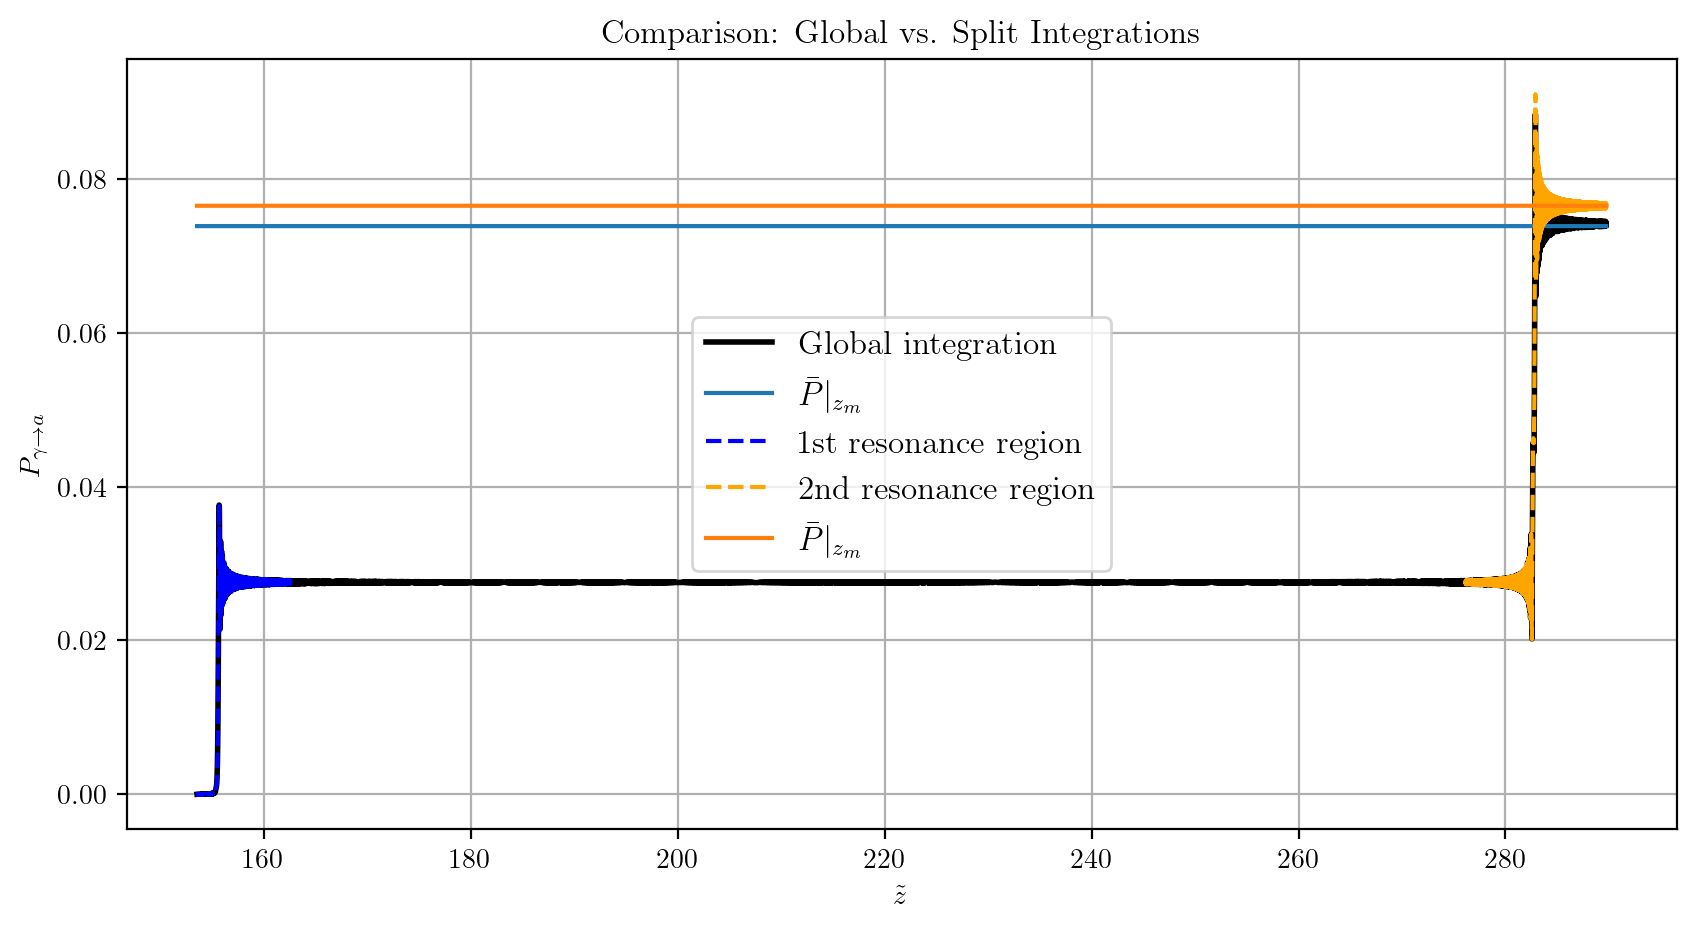

In [104]:
plt.figure(figsize=(10, 5))

# Soluzione globale
plt.plot(z_tilde_thr_cut, p_LZ_1_increasing_decreasing, label='Global integration', color='black', linewidth=2)
plt.plot(z_tilde_thr_cut,P_mean_value_2nd_res*np.ones_like(z_tilde_thr_cut), label=r'$\bar{P}|_{z_m}$')

# Primo intervallo
plt.plot(z_tilde_thr_cut1, p_LZ_1_increasing_decreasing1, label='1st resonance region', linestyle='--', color='blue')

# Secondo intervallo
plt.plot(z_tilde_thr_cut2, p_LZ_1_increasing_decreasing2, label='2nd resonance region', linestyle='--', color='orange')
plt.plot(z_tilde_thr_cut,P_mean_value_2nd_res2*np.ones_like(z_tilde_thr_cut), label=r'$\bar{P}|_{z_m}$')

plt.xlabel(r'$\tilde{z}$')
plt.ylabel(r'$P_{\gamma \rightarrow a}$')
plt.title('Comparison: Global vs. Split Integrations')
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

In [105]:
Difference =np.abs( (P_mean_value_2nd_res-P_mean_value_2nd_res2)/P_mean_value_2nd_res)
Difference

np.float64(0.035826569552038674)